## PPC

In [1]:
import sys
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import sparse

sns.set(context="notebook", font_scale=1.3, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=False

sys.path.append("../utils/")
from totalppc import TotalPosteriorPredictiveCheck as totalPPC
from scvi import set_seed

# colors = ["#9b59b6", "#3498db", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]
# colors_3 = ["#9b59b6", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
colors_3 = ["#3B7EA1", "#D9661F", "#859438", "#EE1F60", "#00A598"]

set_seed(0)

In [2]:
anndataset_pbmc = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_malt = anndata.read(save_path + "malt_10k_protein_v3.h5ad")
anndataset_sln = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_sln = anndataset_sln[anndataset_sln.obs["batch_indices"] == 0]

In [3]:
dataset_pbmc = AnnDatasetFromAnnData(ad=anndataset_pbmc)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_pbmc.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_pbmc.uns["protein_names"],
)
dataset_pbmc.initialize_cell_measurement(protein_data)

dataset_malt = AnnDatasetFromAnnData(ad=anndataset_malt)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_malt.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_malt.uns["protein_names"],
)
dataset_malt.initialize_cell_measurement(protein_data)

# Removes HTOs
dataset_sln = AnnDatasetFromAnnData(ad=anndataset_sln)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_sln.obsm["protein_expression"][:, :-2].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_sln.uns["protein_names"][:-2],
)
dataset_sln.initialize_cell_measurement(protein_data)

datasets = [dataset_pbmc, dataset_malt, dataset_sln]

[2020-09-02 16:26:49,675] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-02 16:26:49,677] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-02 16:26:49,892] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 16:26:50,088] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-09-02 16:26:50,636] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-02 16:26:50,637] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-02 16:26:50,868] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 16:26:51,072] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-09-02 16:26:51,637] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-02 16:26:51,639] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-02 16:26:51,889] INFO - scvi.dataset.dataset | Computing the library size for the new data
[20

In [4]:
for d in datasets:
    d.update_genes(d.var["highly_variable"])

[2020-09-02 16:26:52,185] INFO - scvi.dataset.dataset | Downsampling from 16727 to 4000 genes
[2020-09-02 16:26:52,305] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 16:26:52,400] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-02 16:26:52,493] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 16:26:52,540] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-09-02 16:26:52,541] INFO - scvi.dataset.dataset | Downsampling from 16659 to 4000 genes
[2020-09-02 16:26:52,690] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 16:26:52,770] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-02 16:26:52,851] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 16:26:52,899] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-09-02 16:26:52,901] INFO - scvi.dataset.datase

In [5]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [6]:
vae_pbmcs = {}
vae_malts = {}
vae_slns = {}

for n, r in zip(["Dim(z) = 5", "Dim(z) = 10", "Dim(z) = 20", "Dim(z) = 100"], [5, 10, 20, 100]):
    vae_pbmcs[n] = TOTALVI(dataset_pbmc.nb_genes, len(dataset_pbmc.protein_names), n_latent=r)
    vae_malts[n] = TOTALVI(dataset_malt.nb_genes, len(dataset_malt.protein_names), n_latent=r)
    vae_slns[n] = TOTALVI(dataset_sln.nb_genes, len(dataset_sln.protein_names), n_latent=r)

trainer_pbmcs = {}
trainer_malts = {}
trainer_slns = {}
             
for key, val in vae_pbmcs.items():
    t = TotalTrainer(
        val,
        dataset_pbmc,
        train_size=0.80,
        test_size=0.05,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory": False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainer_pbmcs[key] = t
    t.train(lr=lr, n_epochs=500)

for key, val in vae_malts.items():
    t = TotalTrainer(
        val,
        dataset_malt,
        train_size=0.80,
        test_size=0.05,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory": False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainer_malts[key] = t
    t.train(lr=lr, n_epochs=500)

             
for key, val in vae_slns.items():
    t = TotalTrainer(
        val,
        dataset_sln,
        train_size=0.80,
        test_size=0.05,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory": False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainer_slns[key] = t
    t.train(lr=lr, n_epochs=500)


[2020-09-02 16:37:08,521] INFO - scvi.inference.trainer | Reducing LR on epoch 490.



[2020-09-02 16:46:01,685] INFO - scvi.inference.trainer | Reducing LR on epoch 487.



[2020-09-02 16:52:41,767] INFO - scvi.inference.trainer | Reducing LR on epoch 356.
[2020-09-02 16:53:35,138] INFO - scvi.inference.trainer | Reducing LR on epoch 410.
[2020-09-02 16:54:19,810] INFO - scvi.inference.trainer | Reducing LR on epoch 449.
[2020-09-02 16:54:50,990] INFO - scvi.inference.trainer | Reducing LR on epoch 482.



[2020-09-02 17:01:29,401] INFO - scvi.inference.trainer | Reducing LR on epoch 361.
[2020-09-02 17:02:11,021] INFO - scvi.inference.trainer | Reducing LR on epoch 400.
[2020-09-02 17:03:55,436] INFO - scvi.inference.trainer | Reducing LR on epoch 494.



[2020-09-02 17:09:41,492] INFO - scvi.inference.trainer | Reducing LR on epoch 306.



[2020-09-02 17:18:24,037] INFO - scvi.inference.trainer | Reducing LR on epoch 284.
[2020-09-02 17:20:18,783] INFO - scvi.inference.trainer | Reducing LR on epoch 384.
[2020-09-02 17:21:08,932] INFO - scvi.inference.trainer | Reducing LR on epoch 427.
[2020-09-02 17:21:26,056] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-02 17:21:26,057] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


[2020-09-02 17:28:19,058] INFO - scvi.inference.trainer | Reducing LR on epoch 404.
[2020-09-02 17:29:24,034] INFO - scvi.inference.trainer | Reducing LR on epoch 476.
[2020-09-02 17:29:40,848] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-02 17:29:40,850] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


[2020-09-02 17:36:26,843] INFO - scvi.inference.trainer | Reducing LR on epoch 386.
[2020-09-02 17:37:38,378] INFO - scvi.inference.trainer | Reducing LR on epoch 460.



[2020-09-02 17:48:31,618] INFO - scvi.inference.trainer | Reducing LR on epoch 458.



[2020-09-02 17:57:06,866] INFO - scvi.inference.trainer | Reducing LR on epoch 330.
[2020-09-02 17:58:13,486] INFO - scvi.inference.trainer | Reducing LR on epoch 375.
[2020-09-02 17:59:00,410] INFO - scvi.inference.trainer | Reducing LR on epoch 411.
[2020-09-02 18:00:36,610] INFO - scvi.inference.trainer | Reducing LR on epoch 475.



[2020-09-02 18:09:59,779] INFO - scvi.inference.trainer | Reducing LR on epoch 357.
[2020-09-02 18:11:16,998] INFO - scvi.inference.trainer | Reducing LR on epoch 429.
[2020-09-02 18:12:11,566] INFO - scvi.inference.trainer | Reducing LR on epoch 480.
[2020-09-02 18:12:27,614] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-02 18:12:27,616] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


[2020-09-02 18:20:52,559] INFO - scvi.inference.trainer | Reducing LR on epoch 427.
[2020-09-02 18:21:53,632] INFO - scvi.inference.trainer | Reducing LR on epoch 467.



In [7]:
post_pbmc = {k : t.train_set for k, t in trainer_pbmcs.items()}
post_malt = {k : t.train_set for k, t in trainer_malts.items()}
post_sln = {k : t.train_set for k, t in trainer_slns.items()}

In [ ]:
ppc_held_pbmc = totalPPC(
    posteriors_dict={k : t.validation_set for k, t in trainer_pbmcs.items()},
    n_samples=150,
)
ppc_full_pbmc = totalPPC(
    posteriors_dict=post_pbmc,
    n_samples=25,
)
ppc_held_malt = totalPPC(
    posteriors_dict={k : t.validation_set for k, t in trainer_malts.items()},
    n_samples=150,
)
ppc_full_malt = totalPPC(
    posteriors_dict=post_malt,
    n_samples=25,
)

ppc_held_sln = totalPPC(
    posteriors_dict={k : t.validation_set for k, t in trainer_slns.items()},
    n_samples=150,
)
ppc_full_sln = totalPPC(
    posteriors_dict=post_sln,
    n_samples=25,
)

In [ ]:
ppc_helds = [ppc_held_pbmc, ppc_held_malt, ppc_held_sln]

In [ ]:
for p in ppc_helds:
    p.mean_absolute_error()

In [ ]:
for p in ppc_helds:
    print(p.metrics["mean_ae"])

In [12]:
for p in ppc_helds:
    p.calibration_error(confidence_intervals=[0.5, 99.5])

In [13]:
ppc_held_pbmc.metrics["calibration"]

,Dim(z) = 5,Dim(z) = 10,Dim(z) = 20,Dim(z) = 100
genes,0.000039,0.000039,0.000040,0.000040
proteins,0.000026,0.000071,0.000019,0.000016
total,0.000039,0.000039,0.000039,0.000040


In [14]:
def ppc_bar_plots(key="mean_ae"):
#     cols = ["totalVI", "totalVI", "FA (Log Rate)", "FA (Log)"]
    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    mae_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_genes.loc["PBMC", :] = ppc_held_pbmc.metrics[key].loc["genes"]
    mae_genes.loc["MALT", :] = ppc_held_malt.metrics[key].loc["genes"]
    mae_genes.loc["SLN111-D1", :] = ppc_held_sln.metrics[key].loc["genes"]
    mae_proteins = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_proteins.loc["PBMC", :] = ppc_held_pbmc.metrics["mean_ae"].loc["proteins"]
    mae_proteins.loc["MALT", :] = ppc_held_malt.metrics["mean_ae"].loc["proteins"]
    mae_proteins.loc["SLN111-D1", :] = ppc_held_sln.metrics["mean_ae"].loc["proteins"]


#     mae_genes[cols].plot(kind="bar", ax=ax.flat[0], legend=False, color=colors)
    mae_genes.plot(kind="bar", ax=ax.flat[0], legend=False, color=colors)
    print(mae_proteins)
    mae_proteins.plot(kind="bar", ax=ax.flat[1], legend=False, color=colors)

    cal_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    cal_genes.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["genes"]
    cal_genes.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["genes"]
    cal_genes.loc["SLN111-D1", :] = ppc_held_sln.metrics["calibration"].loc["genes"]
    cal_proteins = cal_genes.copy()
    cal_proteins.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["SLN111-D1", :] = ppc_held_sln.metrics["calibration"].loc["proteins"]

    print(cal_proteins)
#     cal_genes[cols].plot(kind="bar", ax=ax.flat[2], legend=False, color=colors)
    cal_genes.plot(kind="bar", ax=ax.flat[2], legend=False, color=colors)
    cal_proteins.plot(kind="bar", ax=ax.flat[3], legend=False, color=colors)

#     ax.flat[0].set_yscale('log')
    ax.flat[1].set_yscale('log')
#     ax.flat[2].set_yscale('log')
    ax.flat[3].set_yscale('log')


    ax.flat[2].legend(fancybox=True, shadow=True, bbox_to_anchor=(0.1, -0.4))
    for a in ax.flat:
        a.tick_params(axis="x", rotation=0)
    ax.flat[0].set_title("Genes")
    ax.flat[1].set_title("Proteins")
    ax.flat[0].set_ylabel("Mean Absolute Error")
    ax.flat[2].set_ylabel("Calibration Error")
    sns.despine()
    

          Dim(z) = 5 Dim(z) = 10 Dim(z) = 20 Dim(z) = 100
PBMC         164.093     152.853     152.685      158.651
MALT         123.016     110.743     110.012      118.707
SLN111-D1     9.5055     8.20306     8.01883      7.96221
            Dim(z) = 5  Dim(z) = 10  Dim(z) = 20 Dim(z) = 100
PBMC       2.57843e-05  7.07787e-05  1.92106e-05  1.57299e-05
MALT       3.20827e-05  1.94572e-05  2.97604e-05  1.88478e-05
SLN111-D1  5.52384e-06  2.94269e-06  2.20925e-06  1.35875e-06


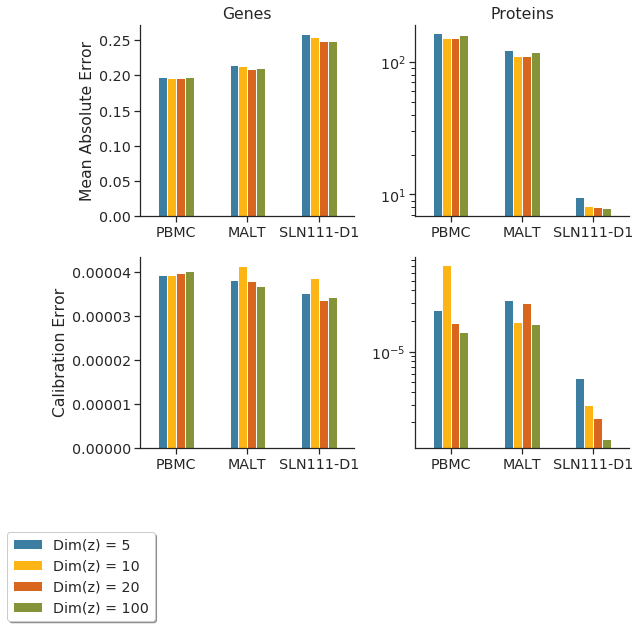

In [15]:
ppc_bar_plots(key="mean_ae")
plt.tight_layout()
plt.savefig("figures/totalvi_nlatent/mae_cal.pdf")

In [16]:
for p in ppc_helds:
    del p

In [17]:
# del p for p in ppc_helds
ppc_fulls = [ppc_full_pbmc, ppc_full_malt, ppc_full_sln]

In [ ]:
# Runtime warning is when samples have all zeros, we consider this as 0 cv
for p in ppc_fulls:
    p.coeff_of_variation(cell_wise=False)

../utils/totalppc.py:115: RuntimeWarning: invalid value encountered in true_divide
  np.std(samples, axis=axis) / np.mean(samples, axis=axis), axis=-1


In [19]:
cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln = {}, {}, {}
cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln = {}, {}, {}
cv_gene_maes = [cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln]
cv_pro_maes = [cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln]

for p, dataset, cv_gene_mae, cv_pro_mae in zip(ppc_fulls, datasets, cv_gene_maes, cv_pro_maes):
    for m, samples in p.posterior_predictive_samples.items():
        cv_gene_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[: dataset.nb_genes]
                - p.metrics["cv_gene"]["raw"].iloc[: dataset.nb_genes]
            )
        )]
        cv_pro_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[dataset.nb_genes:]
                - p.metrics["cv_gene"]["raw"].iloc[dataset.nb_genes:]
            )
        )]
    p.metrics["cv_gene_mae"] = pd.DataFrame.from_dict(cv_gene_mae)
    p.metrics["cv_pro_mae"] = pd.DataFrame.from_dict(cv_pro_mae)

In [20]:
(p.metrics["cv_gene_mae"].iloc[: dataset.nb_genes] == 0).sum(axis=0)

Dim(z) = 5      0
Dim(z) = 10     0
Dim(z) = 20     0
Dim(z) = 100    0
dtype: int64

[[0.66 0.64 0.71 0.72]]
[['0.66' '0.64' '0.71' '0.72' '--']]
[[1.64 1.41 1.42 1.44]]
[['1.64' '1.41' '1.42' '1.44' '--']]
[[1.04 1.09 1.17 1.13]]
[['1.04' '1.09' '1.17' '1.13' '--']]


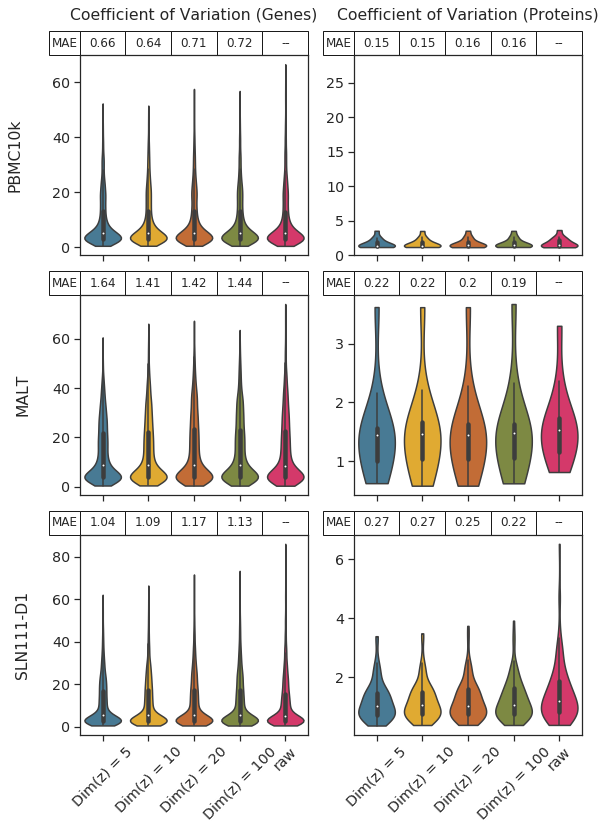

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(9, 12.5), sharex=False)
inds = [0, 2, 4]
for i, p, dataset in zip(inds, ppc_fulls, datasets):
    gene_table = np.round(p.metrics["cv_gene_mae"].values, 2)
    print(gene_table)
    gene_table = np.concatenate([gene_table, np.array(["--"]).reshape(1, 1)], axis=1)
    print(gene_table)
    pro_table = np.round(p.metrics["cv_pro_mae"].values, 2)
    pro_table = np.concatenate([pro_table, np.array(["--"]).reshape(1, 1)], axis=1)
    sns.set_palette(colors)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[: dataset.nb_genes],
        ax=ax.flat[i],
        cut=0,
        scale="count",
#         order=["totalVI", "scVI", "FA (Log)", "FA (Log Rate)", "raw"]
    )
    the_table = ax.flat[i].table(
        cellText=gene_table, rowLabels=["MAE"], loc="top", cellLoc="center"
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)
    
    sns.set_palette(colors)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[dataset.nb_genes :],
        ax=ax.flat[i + 1],
        cut=0,
        scale="count",
#         order=["totalVI", "FA (Log)", "FA (Log Rate)", "raw"]
    )
    the_table = ax.flat[i + 1].table(
        cellText=pro_table,
        loc="top",
        cellLoc="center",
        rowLabels=["MAE"],
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)

title = ax.flat[0].set_title("Coefficient of Variation (Genes)")
title.set_position([0.5, 1.15])
title = ax.flat[1].set_title("Coefficient of Variation (Proteins)")
title.set_position([0.5, 1.15])
ax.flat[1].set_ylim(0, 29)
ax.flat[0].set_xticklabels([])
ax.flat[1].set_xticklabels([])
ax.flat[2].set_xticklabels([])
ax.flat[3].set_xticklabels([])
ax.flat[4].tick_params(axis="x", rotation=45)
ax.flat[5].tick_params(axis="x", rotation=45)
ax.flat[0].set_ylabel("PBMC10k", labelpad=30)
ax.flat[2].set_ylabel("MALT", labelpad=22)
ax.flat[4].set_ylabel("SLN111-D1", labelpad=22)
# sns.despine()

# plt.tight_layout()
plt.savefig("figures/totalvi_nlatent/violins_cv.pdf", bbox_inches="tight")